In [ ]:
!pip install transformers
!pip install pytorch_metric_learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.1 MB/s 
     |████████████████████████████████| 86 kB 2.9 MB/s 
     |████████████████████████████████| 6.6 MB 19.6 MB/s 
     |████████████████████████████████| 596 kB 42.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import pandas as pd
import torch
from torch.nn import functional as F
from torch import nn
from transformers import AutoTokenizer, AutoModel, AutoConfig

Load Pre-trained LM: roberta-base

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
roberta = AutoModel.from_pretrained("roberta-base")

roberta = roberta.train()

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Dataset Loader

In [ ]:
class CustomDataset_train(Dataset):

    def __init__(self, dataframe, tokenizer, max_len, lab2ind):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = self.data.content
        self.labels = self.data.label
        self.max_len = max_len
        self.lab2ind = lab2ind

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])     
        comment_text_augmented = comment_text
        
        label = str(self.labels[index])
        label = self.lab2ind[label]
        
        inputs = self.tokenizer.batch_encode_plus(
            [comment_text, comment_text_augmented],
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=False,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(label, dtype=torch.long)
        }


def regular_encode(file_path, tokenizer, lab2ind, shuffle=True, num_workers = 2, batch_size=64, maxlen = 32):
    # Use pandas to load dataset
    df = pd.read_csv(file_path, delimiter='\t',header=0, names=['content', 'label'], encoding='utf-8', quotechar=None, quoting=3)
    custom_set = CustomDataset_train(df, tokenizer, maxlen,lab2ind)
        
    print("{} Dataset: {}".format(file_path, df.shape))
    
    dataset_params = {'batch_size': batch_size, 'shuffle': shuffle, 'num_workers': num_workers}

    batch_data_loader = DataLoader(custom_set, **dataset_params)
    
    return batch_data_loader

In [ ]:
train_dataloader = regular_encode("/content/drive/MyDrive/Colab_Notebooks/happy_db/train.tsv", tokenizer, {"yes": 1, "no": 0}, True, batch_size= 8, maxlen = 128)

/content/drive/MyDrive/Colab_Notebooks/happy_db/train.tsv Dataset: (8448, 2)


In [ ]:
batch = next(iter(train_dataloader))

In [ ]:
print(batch.keys())

dict_keys(['ids', 'mask', 'targets'])


In [ ]:
print(batch['ids'].shape)

torch.Size([8, 2, 128])


Reshape the inputs. 

input_ids = [batch_size * 2, sequence length]

In [ ]:
input_ids = batch['ids']
input_mask = batch['mask']

input_ids = input_ids.view((-1, input_ids.size(-1)))
input_mask = input_mask.view((-1, input_ids.size(-1)))

print(input_ids.shape)

torch.Size([16, 128])


Use RoBERTa model to encode seuqences. 

In [ ]:
outputs = roberta(input_ids, attention_mask = input_mask, output_hidden_states = True)

In [ ]:
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states'])

Get a seuquence representation from CLS token of each sample.

In [ ]:
cls_embedding = outputs["hidden_states"][-1][:, 0, :]
print(cls_embedding.shape)

torch.Size([16, 768])


In [ ]:
positive_count = 2 ## we have two views
batch_size = 8

## Self-Contrastive Loss (InfoNCE)


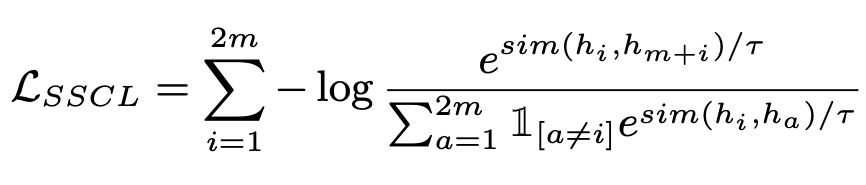

In [ ]:
# temperature \tau
temperature = 1.0

In [ ]:
## normalization
cls_embedding = F.normalize(cls_embedding, dim=1, p=2) 

anchor_feature = cls_embedding
contrast_feature = anchor_feature

Compute Cosine Similarity

In [ ]:
anchor_dot_contrast = torch.div(
    torch.matmul(anchor_feature, contrast_feature.T),
    temperature)

In [ ]:
print(anchor_dot_contrast.shape)
print(anchor_dot_contrast)

torch.Size([16, 16])
tensor([[1.0000, 0.9947, 0.9925, 0.9909, 0.7293, 0.6883, 0.9915, 0.9799, 0.9883,
         0.9909, 0.9921, 0.9883, 0.9870, 0.7168, 0.9941, 0.9938],
        [0.9947, 1.0000, 0.9897, 0.9868, 0.7350, 0.6919, 0.9914, 0.9757, 0.9858,
         0.9878, 0.9891, 0.9846, 0.9790, 0.7223, 0.9941, 0.9946],
        [0.9925, 0.9897, 1.0000, 0.9962, 0.7286, 0.6872, 0.9922, 0.9871, 0.9924,
         0.9946, 0.9954, 0.9929, 0.9909, 0.7167, 0.9913, 0.9913],
        [0.9909, 0.9868, 0.9962, 1.0000, 0.7337, 0.6945, 0.9897, 0.9872, 0.9912,
         0.9935, 0.9943, 0.9925, 0.9907, 0.7212, 0.9881, 0.9892],
        [0.7293, 0.7350, 0.7286, 0.7337, 1.0000, 0.8885, 0.7174, 0.7372, 0.7421,
         0.7226, 0.7240, 0.7345, 0.7253, 0.8611, 0.7300, 0.7313],
        [0.6883, 0.6919, 0.6872, 0.6945, 0.8885, 1.0000, 0.6674, 0.7101, 0.7018,
         0.6825, 0.6827, 0.6984, 0.6920, 0.9228, 0.6880, 0.6897],
        [0.9915, 0.9914, 0.9922, 0.9897, 0.7174, 0.6674, 1.0000, 0.9802, 0.9871,
         0.9913,

Create Self-Supervised Labels

Each sample only has one postive sample that is a copy of itself. 

In [ ]:
labels = torch.arange(batch_size).unsqueeze(1) 

labels = torch.cat([labels, labels], dim=1)
print(labels.shape)

labels = labels.view(-1,1)
print(labels.shape)
print(labels)

torch.Size([8, 2])
torch.Size([16, 1])
tensor([[0],
        [0],
        [1],
        [1],
        [2],
        [2],
        [3],
        [3],
        [4],
        [4],
        [5],
        [5],
        [6],
        [6],
        [7],
        [7]])


In [ ]:
# Cell_ij produces 1 if sample i and sample j have the same label. 
 
mask = torch.eq(labels, labels.T).float()

In [ ]:
mask

tensor([[1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0

Set Diagonal as 0
 
We don't need self-similarity.

In [ ]:
batch_size = cls_embedding.shape[0]

diagonal_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size).view(-1, 1),
            0
        )

In [ ]:
diagonal_mask

tensor([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1

In [ ]:
## It produces 0 for the non-matching places and diagonal and 1 for matching places.
positive_mask = mask * diagonal_mask

In [ ]:
positive_mask

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0

Calculate Elements of Denominator

In [ ]:
exp_denominator = torch.exp(anchor_dot_contrast) * diagonal_mask 


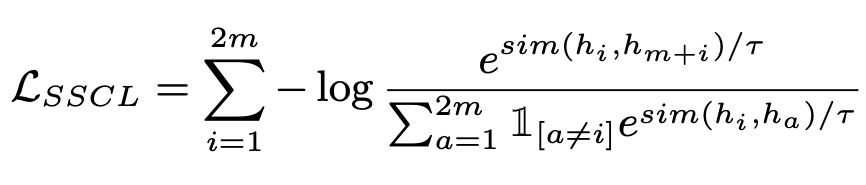

Log(Numerator) - Log(Denominator)

In [ ]:
log_prob = anchor_dot_contrast - torch.log(exp_denominator.sum(1, keepdim=True))

Compute mean of log-likelihood over positive pairs

In [ ]:
log_prob_pos = (positive_mask * log_prob).sum(1)

In [ ]:
loss = -1 * log_prob_pos
loss = loss.mean()

In [ ]:
loss

tensor(2.6643, grad_fn=<MeanBackward0>)

We can use a python package (pytorch_metric_learning) to calculate loss 

In [ ]:
from pytorch_metric_learning import losses

Self-Contrastive loss: [NTXentLoss](https://kevinmusgrave.github.io/pytorch-metric-learning/losses/#ntxentloss)

In [ ]:
loss_fct = losses.NTXentLoss(temperature=1.0)

In [ ]:
loss_fct(cls_embedding, labels.squeeze(1))

tensor(2.6643, grad_fn=<MeanBackward0>)

## Supervised Contrastive Loss

The loss function is similar to self-supervised CL but we use gold labels.

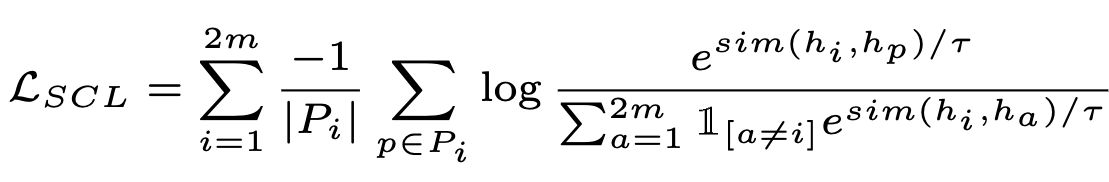

Here, we use gold labels instead of creating self-supervised labels.

In [ ]:
labels = batch['targets'].unsqueeze(1)
labels = torch.cat([labels, labels], dim=1)
print(labels.shape)

labels = labels.view(-1, 1)
print(labels.shape)

torch.Size([8, 2])
torch.Size([16, 1])


One more different: we get mean over positive pairs of each anchor. 

In [ ]:
mean_log_prob_pos = (positive_mask * log_prob).sum(1) / positive_mask.sum(1) # when we run self-SCL positive_mask.sum(1) == 1

Create a class object for our contrastive loss

In [ ]:
class SupConLoss(nn.Module):

    def __init__(self, temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature


    def forward(self, features, labels=None, mask=None):

        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        batch_size = features.shape[0] ## 2*N

        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')

            # Labels are equal or not.
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            print(4)
            mask = mask.float().to(device)


        contrast_feature = features
        anchor_feature = contrast_feature
        anchor_count = 2 ## we have two views


        # compute similarity
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)

        # Set Diagonal as 0
        diagonal_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size).view(-1, 1).to(device),
            0
        )

        ## It produces 0 for the non-matching places and diagonal and 1 for matching places.
        positive_mask = mask * diagonal_mask

        # Calculate Elements of Denominator
        exp_denominator = torch.exp(anchor_dot_contrast) * diagonal_mask

        ## log_prob = x - logsumexp(x1,..,xn) the equation
        log_prob = anchor_dot_contrast - torch.log(exp_denominator.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (positive_mask * log_prob).sum(1) / positive_mask.sum(1)
        
        # loss
        loss = -1 * mean_log_prob_pos
        loss = loss.mean()

        return loss

Use our SupConLoss class

In [ ]:
loss_fct = SupConLoss(temperature=1.0)

In [ ]:
loss_fct(cls_embedding, labels = labels)

tensor(2.6674, grad_fn=<MeanBackward0>)

We can also use [SupConLoss](https://kevinmusgrave.github.io/pytorch-metric-learning/losses/#supconloss) method from pytorch_metric_learning 

In [ ]:
loss_fct2 = losses.SupConLoss(temperature=1.0)

In [ ]:
loss_fct2(cls_embedding, labels = labels.squeeze(1))

tensor(2.6674, grad_fn=<MeanBackward0>)